# Assignment 1: Multi-Layer Perceptron with MNIST Dataset

In this assignment, you are required to train two MLPs to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database by using PyTorch.

The process will be broken down into the following steps:
>1. Load and visualize the data.
2. Define a neural network. (30 marks)
3. Train the models. (30 marks)
4. Evaluate the performance of our trained models on the test dataset. (20 marks)
5. Analysis your results. (20 marks)

In [236]:
import torch
from torch import nn
import numpy as np
import logging
import sys

# set log
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s: %(message)s',
                     datefmt='%Y-%m-%d %H:%M:%S',)

Get the version information of your package

In [237]:
logging.info('The version information:')
logging.info(f'Python: {sys.version}')
logging.info(f'PyTorch: {torch.__version__}')
assert torch.cuda.is_available() == True, 'Please finish your GPU develop environment'

2023-10-13 17:31:12 INFO: The version information:
2023-10-13 17:31:12 INFO: Python: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
2023-10-13 17:31:12 INFO: PyTorch: 1.12.0


---
## Load and Visualize the Data

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [238]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
def classify_label(dataset, num_classes):
    list_index = [[] for _ in range(num_classes)]
    for idx, datum in enumerate(dataset):
        list_index[datum[1]].append(idx)
    return list_index

def partition_train(list_label2indices: list, num_per_class: int):
    random_state = np.random.RandomState(0)
    list_label2indices_train = []
    for indices in list_label2indices:
        random_state.shuffle(indices)
        list_label2indices_train.extend(indices[:num_per_class])
    return list_label2indices_train

class Indices2Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = None

    def load(self, indices: list):
        self.indices = indices

    def __getitem__(self, idx):
        idx = self.indices[idx]
        image, label = self.dataset[idx]
        return image, label

    def __len__(self):
        return len(self.indices)

#  sort train data by label
list_label2indices = classify_label(dataset=train_data, num_classes=10)

# how many samples per class to train
list_train = partition_train(list_label2indices, 500)

# prepare data loaders  
indices2data = Indices2Dataset(train_data)
indices2data.load(list_train)
train_loader = torch.utils.data.DataLoader(indices2data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

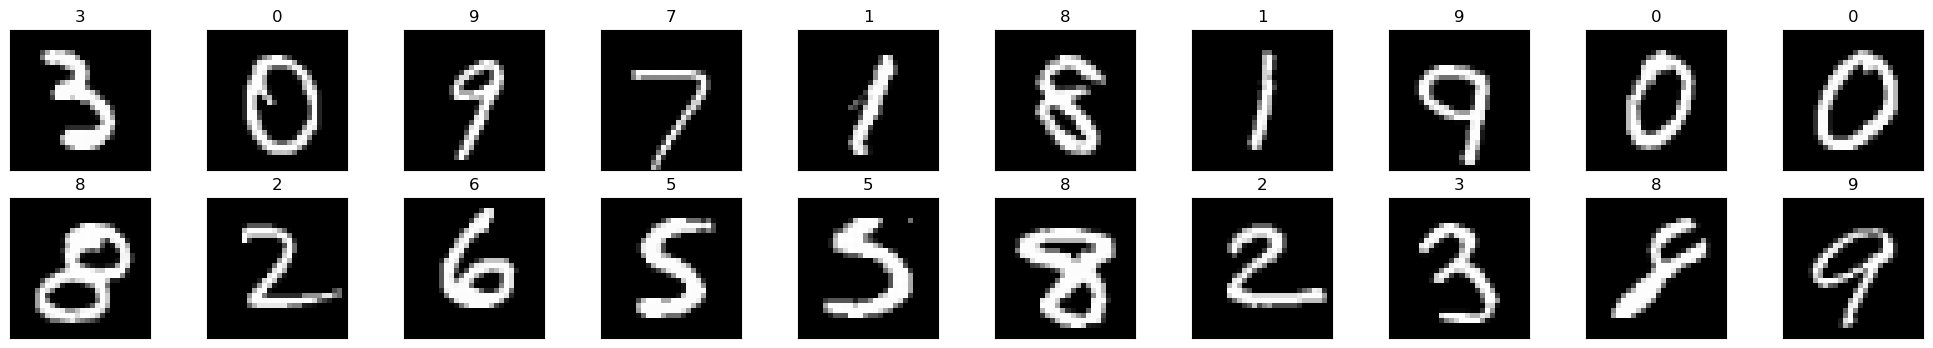

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

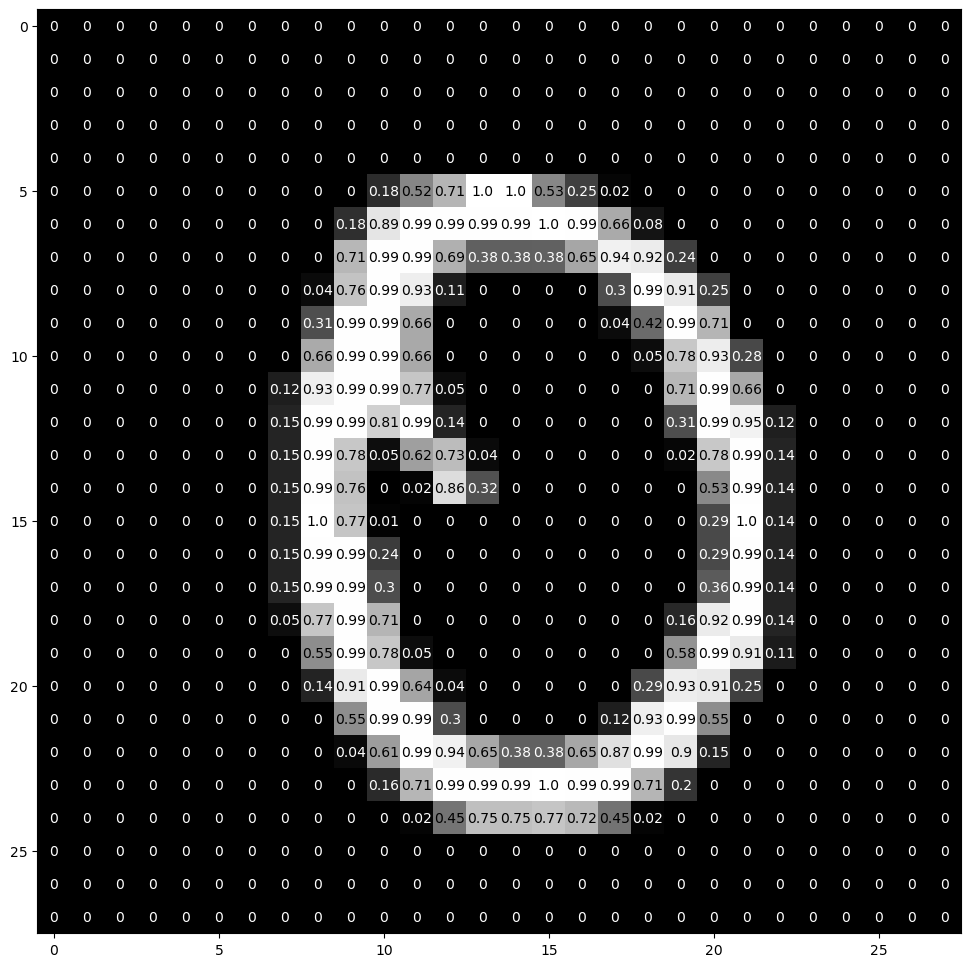

In [240]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Set random seed
A random seed is used to ensure that results are reproducible. In other words, using this parameter makes sure that anyone who re-runs your code will get the exact same outputs. Reproducibility is an extremely important concept in data science and other fields. More details to read: [How to Use Random Seeds Effectively](https://towardsdatascience.com/how-to-use-random-seeds-effectively-54a4cd855a79)

In [241]:
import random
import os

## give the number you like such as 2023
seed_value = 2023

np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

torch.manual_seed(seed_value)     
torch.cuda.manual_seed(seed_value)     
torch.cuda.manual_seed_all(seed_value)   
torch.backends.cudnn.deterministic = True
logging.info(f"tha value of the random seed: {seed_value}")

2023-10-13 17:31:21 INFO: tha value of the random seed: 2023


---
## Define the Network Architecture (30 marks)

* Input: a 784-dim Tensor of pixel values for each image.
* Output: a 10-dim Tensor of number of classes that indicates the class scores for an input image. 

You need to implement three models:
1. a vanilla multi-layer perceptron. (10 marks)
2. a multi-layer perceptron with regularization (dropout or L2 or both). (10 marks)
3. the corresponding loss functions and optimizers. (10 marks)

### Build model_1

In [2]:
## Define the MLP architecture
class VanillaMLP(nn.Module):
    def __init__(self):
        super(VanillaMLP, self).__init__()
        
        # implement your codes here
        self.linear1 = torch.nn.Linear(784,100)
        self.linear2 = torch.nn.Linear(100,10)
        

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)#view ()相当于reshape、resize，重新调整Tensor的形状,-1表示不确定的数

        # implement your codes here
        h_relu = self.linear1(x).clamp(min=0)
        x = self.linear2(h_relu)
        
        
        return x

# initialize the MLP
model_1 = VanillaMLP()

# specify loss function
# implement your codes here
loss_model_1 = torch.nn.CrossEntropyLoss() #十分类任务

# specify your optimizer
# implement your codes here
optimizer_model_1 = torch.optim.SGD(model_1.parameters(),lr=0.05)

NameError: name 'nn' is not defined

### Build model_2

In [243]:
## Define the MLP architecture
class RegularizedMLP(nn.Module):
    def __init__(self):
        super(RegularizedMLP, self).__init__()
        
        # implement your codes here
        self.layer1 = torch.nn.Sequential(
            
            nn.Linear(784,100),
            nn.ReLU(),
            nn.Dropout(0.2),
            )
        self.layer2 =  torch.nn.Sequential(
            nn.Linear(100,10),
            nn.ReLU(), 
            nn.Dropout(0.2)
            #nn.BatchNorm2d(100)
            )
        

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)

        # implement your codes here
        x = self.layer1(x)
        x = self.layer2(x)
        
        return x


# initialize the MLP
model_2 = RegularizedMLP()

# specify loss function
# implement your codes here
loss_model_2 = torch.nn.CrossEntropyLoss()

# specify your optimizer
# implement your codes here
optimizer_model_2 = torch.optim.SGD(model_2.parameters(),lr=0.05)

---
## Train the Network (30 marks)

Train your models in the following two cells.

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

We will introduce some metrics of classification tasks and you will learn how implement these metrics with scikit-learn.

There are supply some references for you to learn: [evaluation_metrics_spring2020](https://cs229.stanford.edu/section/evaluation_metrics_spring2020.pdf).

In training processing, we will use accuracy,  Area Under ROC and top k accuracy.

**The key parts in the training process are left for you to implement.**

### Train model_1
#### Train model_1

In [244]:
# import scikit-learn packages
# please use the function imported from scikit-learn to metric the process of training of the model
from sklearn.metrics import accuracy_score,roc_auc_score, top_k_accuracy_score
# number of epochs to train the model
n_epochs = 20  # suggest training between 20-50 epochs

model_1.train() # prep model for training

train_loss_list = []
train_acc_list = []
train_auc_list = []
train_top_k_acc_list = []


# GPU check
logging.info(f'GPU is available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    gpu_num = torch.cuda.device_count()
    logging.info(f"Train model on {gpu_num} GPUs:")
    for i in range(gpu_num):
        print('\t GPU {}.: {}'.format(i,torch.cuda.get_device_name(i)))
    model_1 = model_1.cuda()

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    pred_array = None
    label_array =  None
    
    one_hot_label_matrix = None
    pred_matrix = None
    

    for data, label in train_loader:
        data = data.cuda()
        label = label.cuda()
        # implement your code here
        
        optimizer_model_1.zero_grad()

        
        pred = model_1(data)
        #torch.Tensor.cpu(pred)
        loss_model_1(pred,label).backward()
        
        optimizer_model_1.step()
        train_loss += loss_model_1(pred,label)

        #label=label.cpu().numpy()
        one_hot_matrix = np.eye(10)[label.cpu().numpy()]
        #print(one_hot_matrix)
       
        # finish the the computation of variables of metric
        # implement your codes here
        if pred_matrix is None:
            pred_matrix = pred.cpu().detach().numpy()     #torch.Tensor.__array__(pred)#y_score  #pred [20,10]
            #print(pred_matrix)
        else:
            pred_matrix = np.concatenate((pred_matrix,pred.cpu().detach().numpy()))

        if one_hot_label_matrix is None:
            one_hot_label_matrix = one_hot_matrix#torch.nn.functional.one_hot(label) #y_true 也应该[20,10]
        else:
            one_hot_label_matrix = np.concatenate((one_hot_label_matrix,one_hot_matrix)) #one_hot_label_matrix.cpu().detach().numpy()

        pred = torch.argmax(pred, axis=1)
        if pred_array is None:
            pred_array = pred.cpu().detach().numpy() #1*20 or 20*1
        else:
            pred_array = np.concatenate((pred_array,pred.cpu().detach().numpy())) #pred_array

        if label_array is None:
            label_array = label.cpu().numpy() #y_true  20*1 没问题
        else:
            label_array = np.concatenate((label_array,label.cpu().numpy()))

        


        
        
    # print training statistics 
    # read the API document at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics to finish your code
    # don't craft your own code
    # calculate average loss and accuracy over an epoch
    
    top_k = 3
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * accuracy_score(label_array, pred_array)
    train_auc = roc_auc_score(one_hot_label_matrix, pred_matrix , multi_class='ovo')
    top_k_acc = top_k_accuracy_score(label_array, pred_matrix , k=top_k,)
    # append the value of the metric to the list
    train_loss_list.append(train_loss.cpu().detach().numpy())
    train_acc_list.append(train_acc)
    train_auc_list.append(train_auc)
    train_top_k_acc_list.append(top_k_acc)
    
    logging.info('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}% \t top {} Acc: {:.2f}% \t AUC Score: {:.4f}'.format(
        epoch+1, 
        train_loss,
        train_acc,
        top_k,
        top_k_acc,
        train_auc,
        ))

2023-10-13 17:31:21 INFO: GPU is available: True
2023-10-13 17:31:21 INFO: Train model on 1 GPUs:


	 GPU 0.: NVIDIA GeForce GTX 1650


2023-10-13 17:31:22 INFO: Epoch: 1 	Training Loss: 0.055782 	Training Acc: 72.66% 	 top 3 Acc: 0.91% 	 AUC Score: 0.8848
2023-10-13 17:31:24 INFO: Epoch: 2 	Training Loss: 0.022577 	Training Acc: 87.36% 	 top 3 Acc: 0.97% 	 AUC Score: 0.9625
2023-10-13 17:31:25 INFO: Epoch: 3 	Training Loss: 0.018006 	Training Acc: 89.66% 	 top 3 Acc: 0.98% 	 AUC Score: 0.9695
2023-10-13 17:31:26 INFO: Epoch: 4 	Training Loss: 0.015784 	Training Acc: 91.10% 	 top 3 Acc: 0.98% 	 AUC Score: 0.9727
2023-10-13 17:31:28 INFO: Epoch: 5 	Training Loss: 0.014200 	Training Acc: 91.80% 	 top 3 Acc: 0.99% 	 AUC Score: 0.9754
2023-10-13 17:31:29 INFO: Epoch: 6 	Training Loss: 0.012953 	Training Acc: 92.36% 	 top 3 Acc: 0.99% 	 AUC Score: 0.9777
2023-10-13 17:31:31 INFO: Epoch: 7 	Training Loss: 0.011576 	Training Acc: 92.94% 	 top 3 Acc: 0.99% 	 AUC Score: 0.9797
2023-10-13 17:31:32 INFO: Epoch: 8 	Training Loss: 0.010691 	Training Acc: 94.10% 	 top 3 Acc: 0.99% 	 AUC Score: 0.9814
2023-10-13 17:31:33 INFO: Epoch:

#### Visualize the training process of the model_1
Please read the [document](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) to finish the training process visualization.
For more information, please refer to the [document](https://matplotlib.org/stable/tutorials/index.html)
##### Plot the change of the loss of model_1 during training

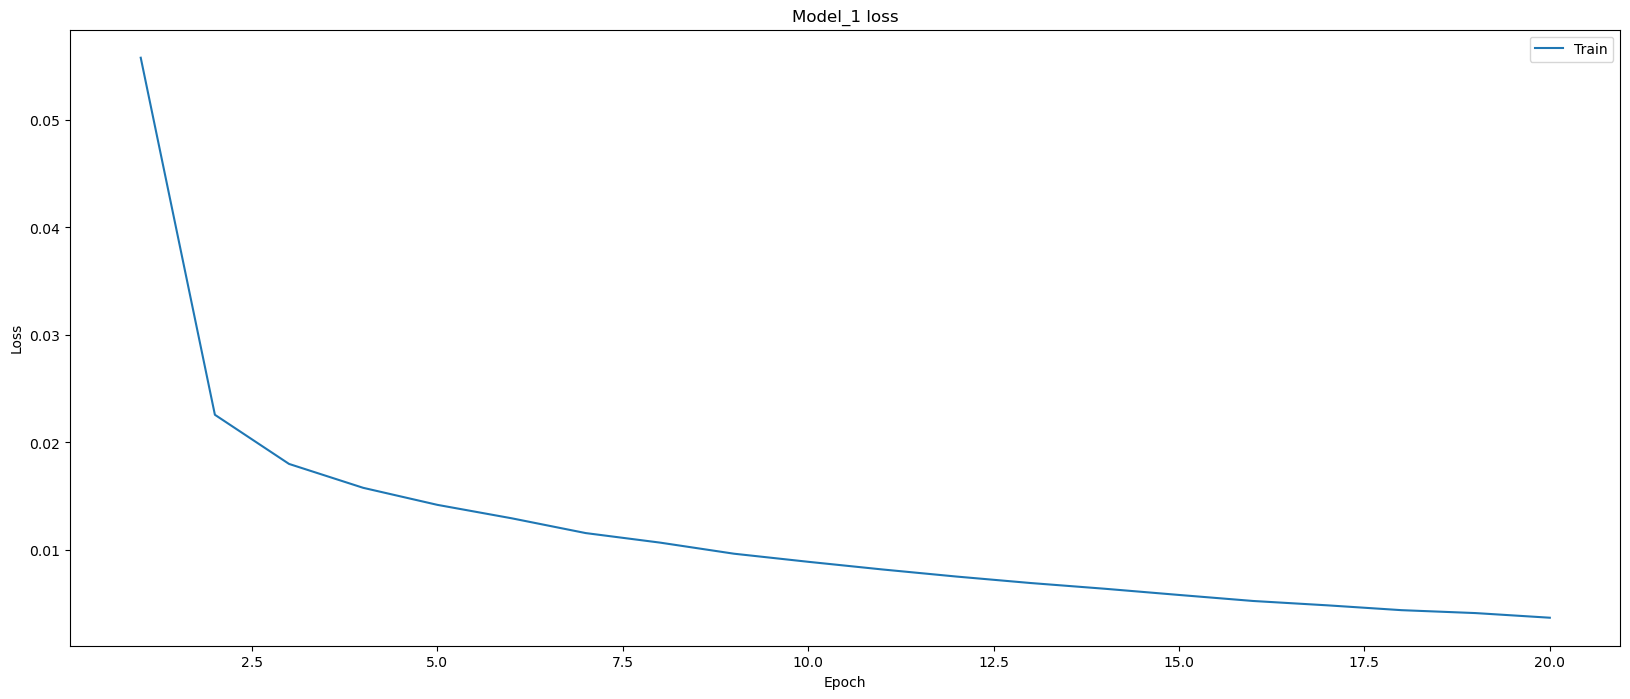

In [245]:
epochs_list = list(range(1,n_epochs+1))
plt.figure(figsize=(20, 8))
plt.plot(epochs_list, train_loss_list)
plt.title('Model_1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

##### Plot the change of the accuracy of model_1 during training

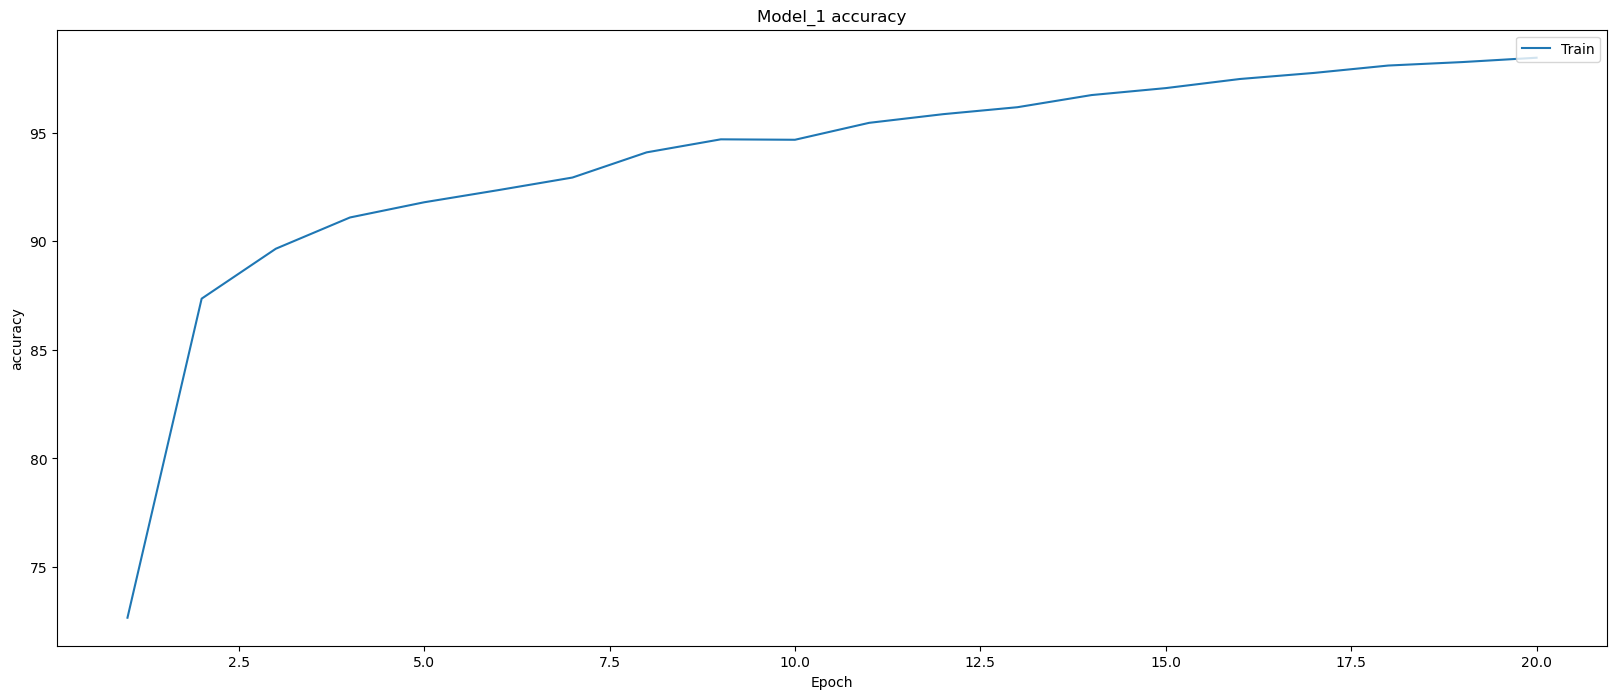

In [246]:
plt.figure(figsize=(20, 8))
plt.plot(epochs_list, train_acc_list)
plt.title('Model_1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

##### Plot the change of the AUC Score of model_1 during training


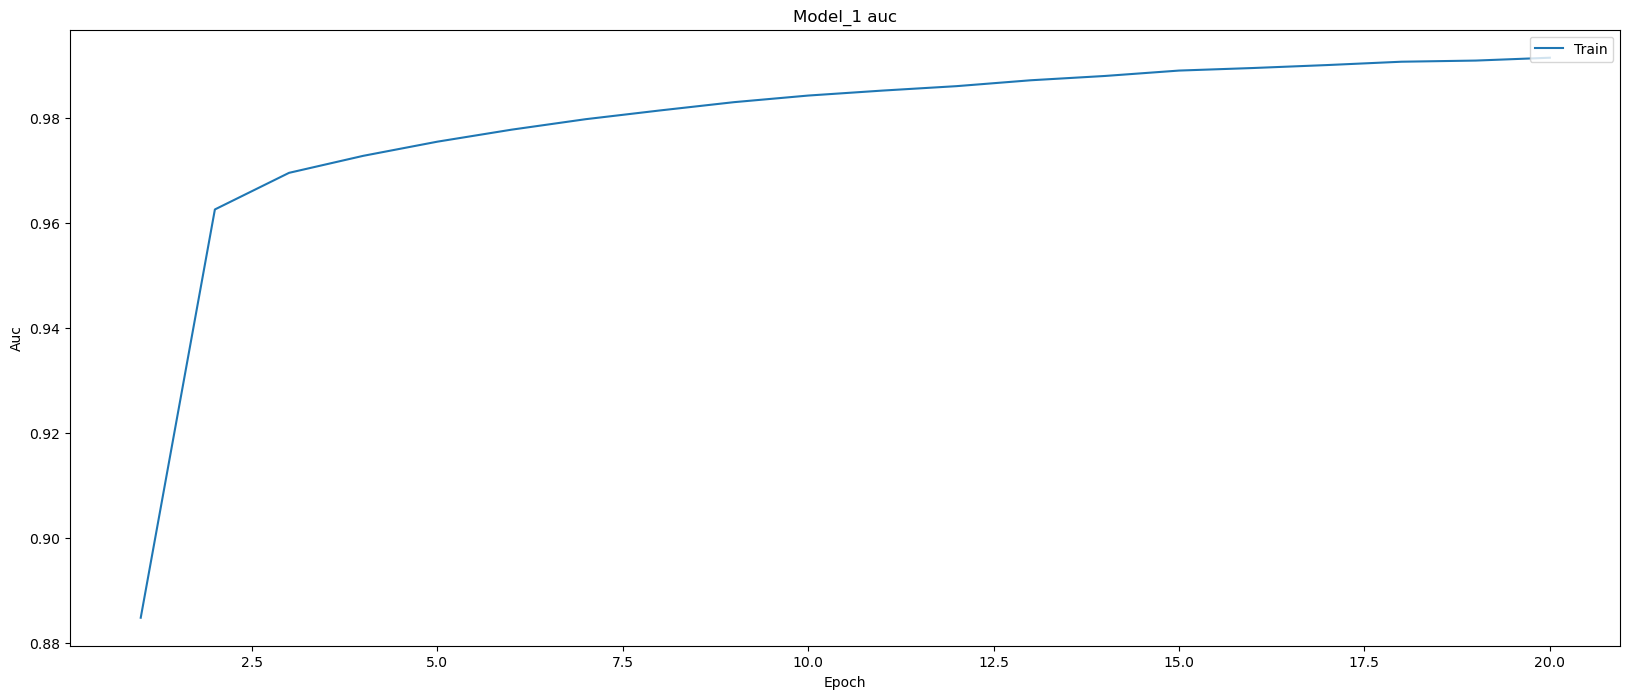

In [247]:
plt.figure(figsize=(20, 8))
plt.plot(epochs_list, train_auc_list)
plt.title('Model_1 auc')
plt.ylabel('Auc')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Train model_2

#### Train model_2

In [248]:
# import scikit-learn packages
# please use the function imported from scikit-learn to metric the process of training of the model
from sklearn.metrics import accuracy_score,roc_auc_score, top_k_accuracy_score
# number of epochs to train the model
n_epochs = 20  # suggest training between 20-50 epochs

model_2.train() # prep model for training

train_loss_list = []
train_acc_list = []
train_auc_list = []
train_top_k_acc_list = []


# GPU check
logging.info(f'GPU is available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    gpu_num = torch.cuda.device_count()
    logging.info(f"Train model on {gpu_num} GPUs:")
    for i in range(gpu_num):
        print('\t GPU {}.: {}'.format(i,torch.cuda.get_device_name(i)))
    model_2 = model_2.cuda()

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    pred_array = None
    label_array =  None
    
    one_hot_label_matrix = None
    pred_matrix = None
    

    for data, label in train_loader:
        data = data.cuda()
        label = label.cuda()
        # implement your code here
        optimizer_model_2.zero_grad()
        pred = model_2(data)

        loss_model_2(pred,label).backward()
        optimizer_model_2.step()
        train_loss += loss_model_2(pred,label)
        #train_loss+=loss.item()*data.size(0)
        optimizer_model_2.zero_grad()

        # finish the the computation of variables of metric
        # implement your codes here
        if pred_matrix is None:
            pred_matrix = pred.cpu().detach().numpy()
        else:
            pred_matrix = np.concatenate((pred_matrix,pred.cpu().detach().numpy()),axis=0)

        if one_hot_label_matrix is None:
            one_hot_label_matrix = np.eye(10)[label.cpu().detach().numpy()]
        else:
            one_hot_label_matrix = np.concatenate((one_hot_label_matrix,np.eye(10)[label.cpu().detach().numpy()]))

        pred = torch.argmax(pred, axis=1)
        if pred_array is None:
            pred_array = pred.cpu().detach().numpy()
        else:
            pred_array = np.concatenate((pred_array,pred.cpu().detach().numpy()))

        if label_array is None:
            label_array = label.cpu().numpy()
        else:
            label_array = np.concatenate((label_array,label.cpu().numpy()))

        


        
        
    # print training statistics 
    # read the API document at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics to finish your code
    # don't craft your own code
    # calculate average loss and accuracy over an epoch
    
    top_k = 3
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * accuracy_score(label_array, pred_array)
    train_auc = roc_auc_score(one_hot_label_matrix, pred_matrix , multi_class='ovo')
    top_k_acc = top_k_accuracy_score(label_array, pred_matrix , k=top_k,)
    # append the value of the metric to the list
    train_loss_list.append(train_loss.cpu().detach().numpy())
    train_acc_list.append(train_acc)
    train_auc_list.append(train_auc)
    train_top_k_acc_list.append(top_k_acc)
    
    logging.info('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}% \t top {} Acc: {:.2f}% \t AUC Score: {:.4f}'.format(
        epoch+1, 
        train_loss,
        train_acc,
        top_k,
        top_k_acc,
        train_auc,
        ))

2023-10-13 17:31:47 INFO: GPU is available: True
2023-10-13 17:31:47 INFO: Train model on 1 GPUs:


	 GPU 0.: NVIDIA GeForce GTX 1650


2023-10-13 17:31:49 INFO: Epoch: 1 	Training Loss: 0.076815 	Training Acc: 55.92% 	 top 3 Acc: 0.71% 	 AUC Score: 0.7593
2023-10-13 17:31:50 INFO: Epoch: 2 	Training Loss: 0.049890 	Training Acc: 70.00% 	 top 3 Acc: 0.81% 	 AUC Score: 0.8553
2023-10-13 17:31:52 INFO: Epoch: 3 	Training Loss: 0.045188 	Training Acc: 71.40% 	 top 3 Acc: 0.82% 	 AUC Score: 0.8643
2023-10-13 17:31:53 INFO: Epoch: 4 	Training Loss: 0.041770 	Training Acc: 73.18% 	 top 3 Acc: 0.83% 	 AUC Score: 0.8714
2023-10-13 17:31:54 INFO: Epoch: 5 	Training Loss: 0.040614 	Training Acc: 73.68% 	 top 3 Acc: 0.83% 	 AUC Score: 0.8720
2023-10-13 17:31:55 INFO: Epoch: 6 	Training Loss: 0.038043 	Training Acc: 75.52% 	 top 3 Acc: 0.84% 	 AUC Score: 0.8797
2023-10-13 17:31:57 INFO: Epoch: 7 	Training Loss: 0.037246 	Training Acc: 75.86% 	 top 3 Acc: 0.84% 	 AUC Score: 0.8813
2023-10-13 17:31:58 INFO: Epoch: 8 	Training Loss: 0.037259 	Training Acc: 75.44% 	 top 3 Acc: 0.83% 	 AUC Score: 0.8767
2023-10-13 17:31:59 INFO: Epoch:

#### Visualize the training process of the model_2
Please read the [document](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) to finish the training process visualization.
For more information, please refer to the [document](https://matplotlib.org/stable/tutorials/index.html)
##### Plot the change of the loss of model_2 during training

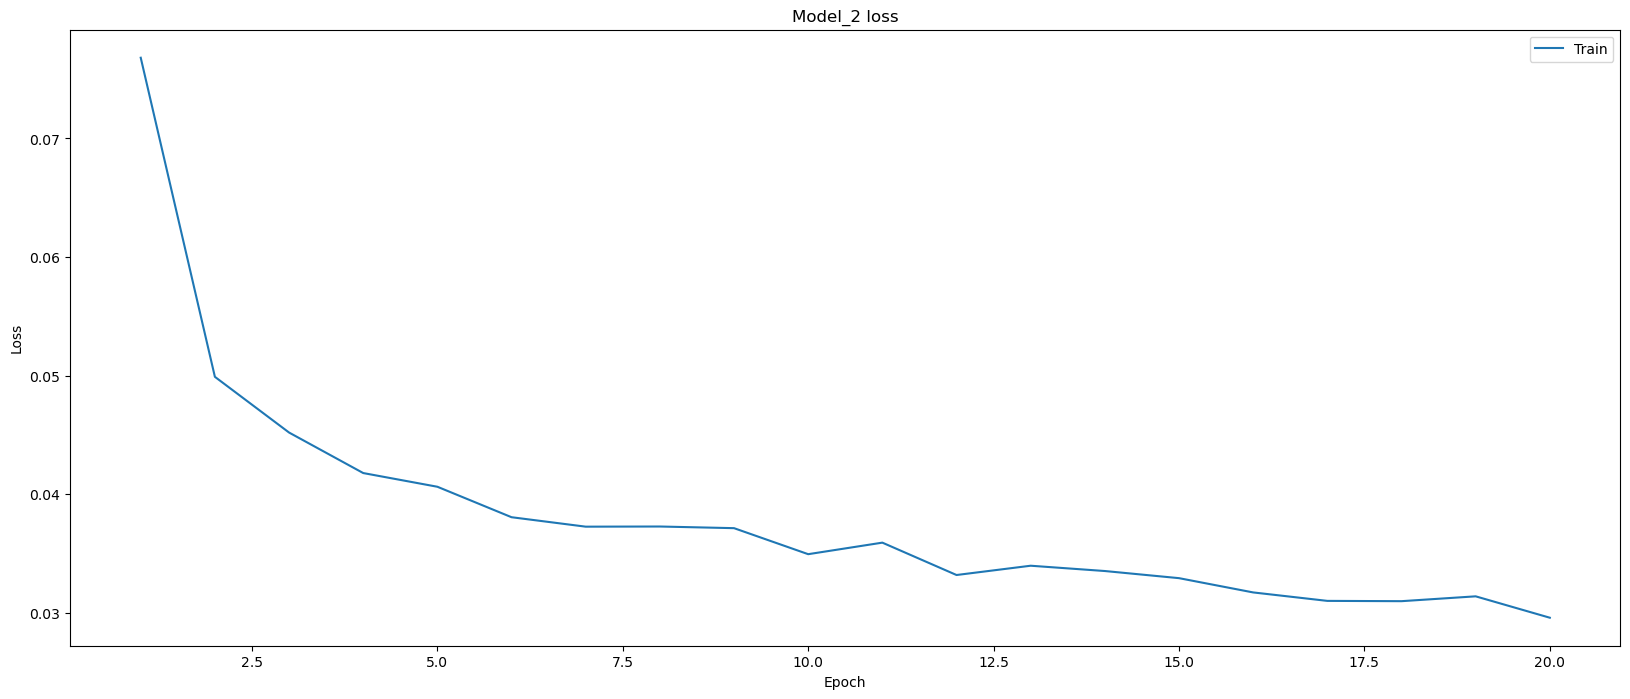

In [249]:
epochs_list = list(range(1,n_epochs+1))
plt.figure(figsize=(20, 8))
plt.plot(epochs_list, train_loss_list)
plt.title('Model_2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

##### Plot the change of the accuracy of model_2 during training

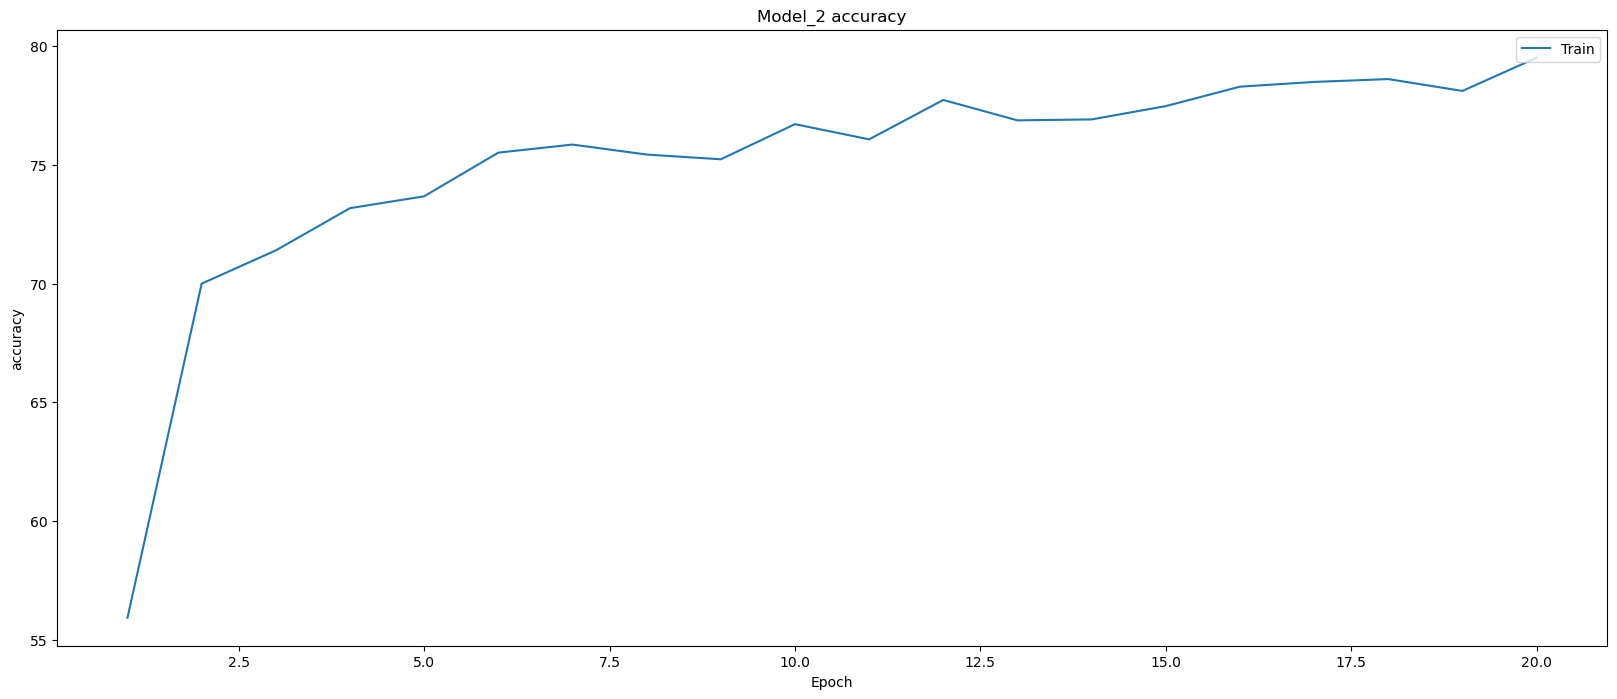

In [250]:
plt.figure(figsize=(20, 8))
plt.plot(epochs_list, train_acc_list)
plt.title('Model_2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

##### Plot the change of the AUC Score of model_2 during training


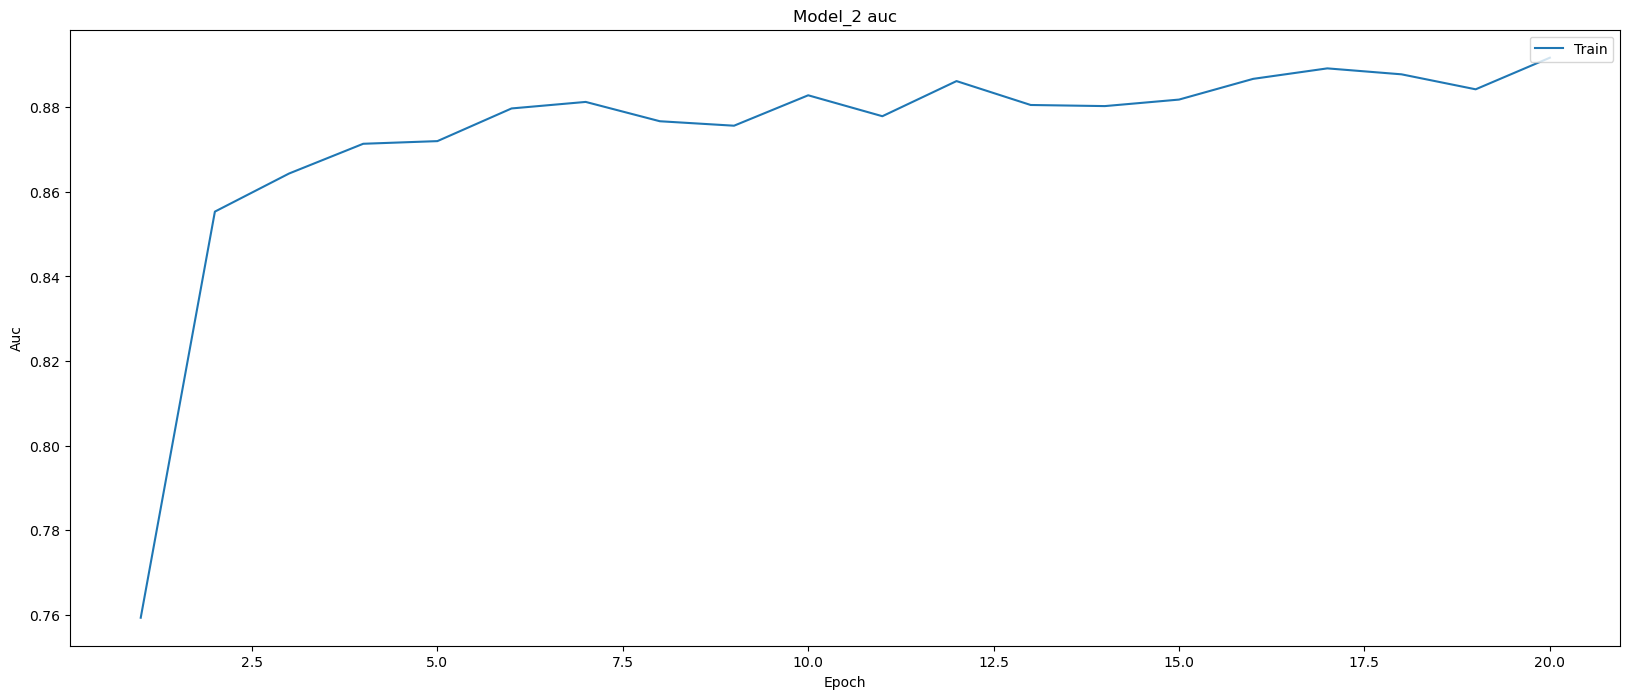

In [251]:
plt.figure(figsize=(20, 8))
plt.plot(epochs_list, train_auc_list)
plt.title('Model_2 auc')
plt.ylabel('Auc')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

---
## Test the Trained Network (20 marks)

Test the performance of trained models on test data. Except the total test accuracy, you should calculate the accuracy for each class.

About metrics, in test processing, we will use accuracy, top k accuracy, precision, recall, f1-score and confusion matrix. 

Besides, we will visualize the confusion matrix.

Last but not least, we will compare your implementation of function to compute accuracy with the implementation of scikit-learn.

In [252]:
## define your implementation of function to compute accuracy
def accuracy_score_manual(label_array, pred_array):
    # implement your codes here
    
    if len(pred_array) != len(label_array):
        raise ValueError("预测值和标签的数量不一致")

    correct_count = 0
    total_count = len(pred_array)

    for i in range(total_count):
        if pred_array[i] == label_array[i]:
            correct_count += 1

    accuracy = correct_count / total_count
    return accuracy

### Test model_1

In [253]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
# initialize lists to monitor test loss and accuracy
test_loss = 0.0

pred_array = None
label_array =  None

one_hot_label_matrix = None
pred_matrix = None

model_1.eval() # prep model for *evaluation*

for data, label in test_loader:
    data = data.cuda()
    label = label.cuda()
    # implement your code here
    pred = model_1(data)
    test_loss += loss_model_1(pred,label)
    
    if pred_matrix is None:
        pred_matrix = pred.cpu().detach().numpy()
    else:
        pred_matrix =  np.concatenate((pred_matrix, pred.cpu().detach().numpy()))

    if one_hot_label_matrix is None:
        one_hot_label_matrix = np.eye(10)[label.cpu().detach().numpy()]
    else:
        one_hot_label_matrix = np.concatenate((one_hot_label_matrix,np.eye(10)[label.cpu().detach().numpy()]))
    pred = torch.argmax(pred, axis=1)
    
    if pred_array is None:
        pred_array = pred.cpu().detach().numpy()
    else:
        pred_array = np.concatenate((pred_array,pred.cpu().detach().numpy()))

    if label_array is None:
        label_array = label.cpu().numpy()
    else:
        label_array = np.concatenate((label_array,label.cpu().numpy()))
# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
test_acc = accuracy_score(label_array, pred_array)
test_auc = roc_auc_score(one_hot_label_matrix, pred_matrix , multi_class='ovo')
test_top_k3_acc = top_k_accuracy_score(label_array, pred_matrix , k=3)
test_top_k5_acc = top_k_accuracy_score(label_array, pred_matrix , k=5)
logging.info('Test Loss: {:.6f}'.format(test_loss))
logging.info('Test Accuracy: {:.6f}'.format(test_acc))
logging.info('Test top 3 Accuracy: {:.6f}'.format(test_top_k3_acc ))
logging.info('Test top 5 Accuracy: {:.6f}'.format(test_top_k5_acc ))
logging.info('The classification report of test for model_1')
print(classification_report(label_array, pred_array))

2023-10-13 17:32:16 INFO: Test Loss: 0.011951
2023-10-13 17:32:16 INFO: Test Accuracy: 0.930600
2023-10-13 17:32:16 INFO: Test top 3 Accuracy: 0.987700
2023-10-13 17:32:16 INFO: Test top 5 Accuracy: 0.996600
2023-10-13 17:32:16 INFO: The classification report of test for model_1


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.96      0.99      0.97      1135
           2       0.93      0.93      0.93      1032
           3       0.94      0.90      0.92      1010
           4       0.92      0.93      0.93       982
           5       0.90      0.92      0.91       892
           6       0.93      0.94      0.93       958
           7       0.92      0.95      0.93      1028
           8       0.93      0.90      0.91       974
           9       0.95      0.87      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



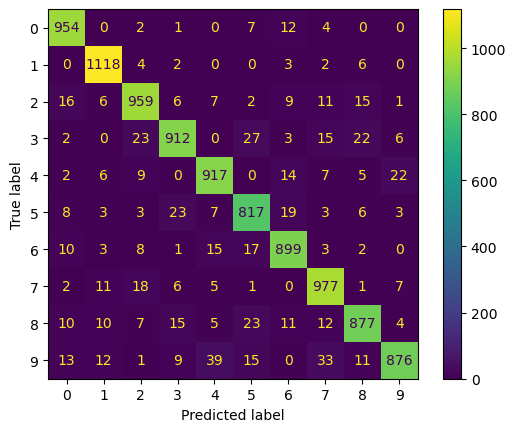

In [254]:
ConfusionMatrixDisplay.from_predictions(label_array,pred_array)
plt.show()

In [255]:
## compare your implementation of function to compute accuracy with the implementation of scikit-learn.
your_test_acc = accuracy_score_manual(label_array, pred_array)
assert abs(your_test_acc - test_acc) < 1e-5 , 'Please check your implementation of function to compute accuracy'

### Test model_2

In [256]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
# initialize lists to monitor test loss and accuracy
test_loss = 0.0

pred_array = None
label_array =  None

one_hot_label_matrix = None
pred_matrix = None

model_2.eval() # prep model for *evaluation*

for data, label in test_loader:
    data = data.cuda()
    label = label.cuda()
    # implement your code here
    pred = model_2(data)
    test_loss += loss_model_2(pred,label)
    
    if pred_matrix is None:
        pred_matrix = pred.cpu().detach().numpy()
    else:
        pred_matrix =  np.concatenate((pred_matrix, pred.cpu().detach().numpy()))

    if one_hot_label_matrix is None:
        one_hot_label_matrix = np.eye(10)[label.cpu().detach().numpy()]
    else:
        one_hot_label_matrix = np.concatenate((one_hot_label_matrix,np.eye(10)[label.cpu().detach().numpy()]))
    pred = torch.argmax(pred, axis=1)
    
    if pred_array is None:
        pred_array = pred.cpu().detach().numpy()
    else:
        pred_array = np.concatenate((pred_array,pred.cpu().detach().numpy()))

    if label_array is None:
        label_array = label.cpu().numpy()
    else:
        label_array = np.concatenate((label_array,label.cpu().numpy()))
# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
test_acc = accuracy_score(label_array, pred_array)
test_auc = roc_auc_score(one_hot_label_matrix, pred_matrix , multi_class='ovo')
test_top_k3_acc = top_k_accuracy_score(label_array, pred_matrix , k=3)
test_top_k5_acc = top_k_accuracy_score(label_array, pred_matrix , k=5)

logging.info('Test Loss: {:.6f}'.format(test_loss))
logging.info('Test Accuracy: {:.6f}'.format(test_acc))
logging.info('Test top 3 Accuracy: {:.6f}'.format(test_top_k3_acc ))
logging.info('Test top 5 Accuracy: {:.6f}'.format(test_top_k5_acc ))
logging.info('The classification report of test for model_2')
print(classification_report(label_array, pred_array))

2023-10-13 17:32:19 INFO: Test Loss: 0.013490
2023-10-13 17:32:19 INFO: Test Accuracy: 0.934200
2023-10-13 17:32:19 INFO: Test top 3 Accuracy: 0.984200
2023-10-13 17:32:19 INFO: Test top 5 Accuracy: 0.988400
2023-10-13 17:32:19 INFO: The classification report of test for model_2


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.90      0.92      1032
           3       0.93      0.92      0.93      1010
           4       0.91      0.94      0.93       982
           5       0.95      0.90      0.93       892
           6       0.95      0.94      0.94       958
           7       0.90      0.96      0.93      1028
           8       0.89      0.93      0.91       974
           9       0.94      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



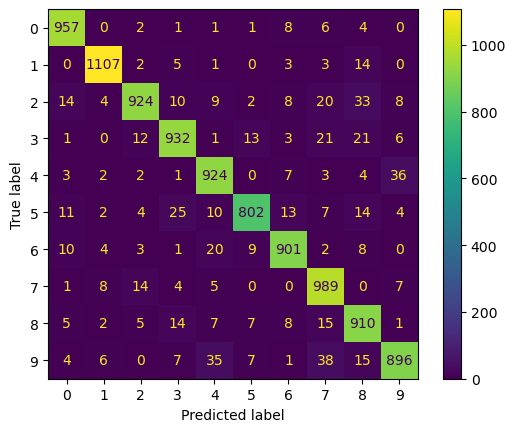

In [257]:
ConfusionMatrixDisplay.from_predictions(label_array,pred_array)
plt.show()

In [258]:
## compare your implementation of function to compute accuracy with the implementation of scikit-learn.
your_test_acc = accuracy_score_manual(label_array, pred_array)
assert abs(your_test_acc - test_acc) < 1e-5 , 'Please check your implementation of function to compute accuracy'

---
## Analyze Your Result (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Does your vanilla MLP overfit to the training data? (5 marks)

Answer:是的，vanilla MLP存在过拟合

2. If yes, how do you observe it? If no, why? (5 marks)

Answer:模型vanilla MLP在训练结束时候training loss还在继续下降但是test_loss在某个点开始不再下降反而开始上升了

3. Is regularized model help prevent overfitting? (5 marks)

Answer:是的，在模型RegularizedMLP中加入了dropout的正则化项，一定程度上解决了过拟合的问题，虽然在训练集上的效果有一点下降，但测试集上的效果有所提升。

4. Generally compare the performance of two models. (5 marks)

Answer:vanillaMLP模型存在过拟合的问题，在测试集上的表现与在训练集上的表现差距较大，RegularizedMLP通过dropout正则化的方法优化了vanillaMLP模型，具有更好的鲁棒性。
